# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune_loyfer"
TITRATING_CELLTYPE = "Blood-CD8"
TITRATING_CELLTYPE_ATLAS = "immune_cd8"
BACKGROUND = "wholeblood"
N_REPLICATES = 20
SEED = 612330
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blood-B", "Blood-CD4", "Blood-CD8", "Blood-Mono+Macro", "Blood-NK", "Blood-Granul"]
ABRIDGED_NAMES = ["B", "CD4", "CD8", "MONO", "NK", "GRANUL"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blood-B": 0.06, "Blood-Mono+Macro": 0.09, "Blood-Granul": 0.57, "Blood-CD4": 0.16, "Blood-CD8": 0.07, "Blood-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2,
 0.05161290322580645,
 0.13763440860215054,
 0.07741935483870968,
 0.043010752688172046,
 0.4903225806451612]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blood-CD8


----------> Loading cell type: Blood-B


----------> Loading cell type: Blood-CD4


----------> Loading cell type: Blood-Mono+Macro


----------> Loading cell type: Blood-NK


----------> Loading cell type: Blood-Granul


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.05161290322580645, 0.13763440860215054, 0.07741935483870968, 0.043010752688172046, 0.4903225806451612]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.05483870967741935, 0.14623655913978492, 0.08225806451612903, 0.0456989247311828, 0.5209677419354838]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.05806451612903226, 0.15483870967741933, 0.08709677419354839, 0.04838709677419355, 0.5516129032258064]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.05935483870967742, 0.1582795698924731, 0.08903225806451613, 0.049462365591397855, 0.5638709677419355]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.060645161290322575, 0.16172043010752685, 0.09096774193548386, 0.05053763440860215, 0.5761290322580644]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.061935483870967735, 0.16516129032258062, 0.0929032258064516, 0.05161290322580645, 0.5883870967741934]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.0632258064516129, 0.1686021505376344, 0.09483870967741935, 0.05268817204301075, 0.6006451612903225]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.06387096774193549, 0.1703225806451613, 0.09580645161290323, 0.0532258064516129, 0.606774193548387]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.064, 0.17066666666666666, 0.096, 0.05333333333333334, 0.6079999999999999]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.06412903225806452, 0.17101075268817204, 0.09619354838709678, 0.053440860215053766, 0.6092258064516128]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.06425806451612903, 0.1713548387096774, 0.09638709677419355, 0.053548387096774196, 0.6104516129032257]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.06438709677419355, 0.17169892473118278, 0.09658064516129032, 0.053655913978494625, 0.6116774193548387]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.0644516129032258, 0.17187096774193547, 0.0966774193548387, 0.05370967741935484, 0.6122903225806451]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.06451612903225806, 0.17204301075268816, 0.0967741935483871, 0.053763440860215055, 0.6129032258064515]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.51 s, sys: 333 ms, total: 1.84 s
Wall time: 24min 46s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
# %%time
# ridxs = ~cpg_map['cpg_index_hg38'].isna()
# hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
# hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

# region_df['region_cpg_index_max'] -= 1
# region_df.sort_values('region_cpg_index_min', inplace=True)
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
# ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
# ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [14]:
# cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
# cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
# ridxs = (cg_count_hg19==cg_count_hg38)
# ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [15]:
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id
0,chr1,1114771,1114971,20117,20130,Immune_Broad_B-chr1:1114772-1114971
1,chr1,1157450,1157720,21684,21704,Immune_Broad_NK-chr1:1157451-1157720
2,chr1,1157879,1158277,21710,21727,Immune_Broad_NK-chr1:1157880-1158277
14,chr1,6341182,6341377,140667,140682,Immune_Broad_Eosi-chr1:6341183-6341377
19,chr1,9147788,9147871,188605,188609,Immune_Broad_Neutro-chr1:9147789-9147871


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2CD8_E0516B_E1376CD4_E0774MONO_E043NK_E4903GRANUL
--------> Computing score matrix for mix0_seed10677


--------> Computing score matrix for mix1_seed793202


--------> Computing score matrix for mix2_seed262892


--------> Computing score matrix for mix3_seed621685


--------> Computing score matrix for mix4_seed834113


--------> Computing score matrix for mix5_seed938049


--------> Computing score matrix for mix6_seed438914


--------> Computing score matrix for mix7_seed820194


--------> Computing score matrix for mix8_seed569299


--------> Computing score matrix for mix9_seed641875


--------> Computing score matrix for mix10_seed516429


--------> Computing score matrix for mix11_seed551008


--------> Computing score matrix for mix12_seed451251


--------> Computing score matrix for mix13_seed46440


--------> Computing score matrix for mix14_seed32761


--------> Computing score matrix for mix15_seed453928


--------> Computing score matrix for mix16_seed127945


--------> Computing score matrix for mix17_seed339966


--------> Computing score matrix for mix18_seed678895


--------> Computing score matrix for mix19_seed56597




--> E15CD8_E0548B_E1462CD4_E0823MONO_E0457NK_E521GRANUL
--------> Computing score matrix for mix0_seed711506


--------> Computing score matrix for mix1_seed552514


--------> Computing score matrix for mix2_seed455087


--------> Computing score matrix for mix3_seed794469


--------> Computing score matrix for mix4_seed618050


--------> Computing score matrix for mix5_seed3225


--------> Computing score matrix for mix6_seed242344


--------> Computing score matrix for mix7_seed58020


--------> Computing score matrix for mix8_seed676423


--------> Computing score matrix for mix9_seed539304


--------> Computing score matrix for mix10_seed326800


--------> Computing score matrix for mix11_seed332055


--------> Computing score matrix for mix12_seed104820


--------> Computing score matrix for mix13_seed453901


--------> Computing score matrix for mix14_seed62296


--------> Computing score matrix for mix15_seed166480


--------> Computing score matrix for mix16_seed382183


--------> Computing score matrix for mix17_seed241731


--------> Computing score matrix for mix18_seed390227


--------> Computing score matrix for mix19_seed788404




--> E1CD8_E0581B_E1548CD4_E0871MONO_E0484NK_E5516GRANUL
--------> Computing score matrix for mix0_seed339352


--------> Computing score matrix for mix1_seed738226


--------> Computing score matrix for mix2_seed746046


--------> Computing score matrix for mix3_seed512129


--------> Computing score matrix for mix4_seed573712


--------> Computing score matrix for mix5_seed610437


--------> Computing score matrix for mix6_seed548968


--------> Computing score matrix for mix7_seed845164


--------> Computing score matrix for mix8_seed885837


--------> Computing score matrix for mix9_seed869303


--------> Computing score matrix for mix10_seed925892


--------> Computing score matrix for mix11_seed630735


--------> Computing score matrix for mix12_seed665140


--------> Computing score matrix for mix13_seed560454


--------> Computing score matrix for mix14_seed262515


--------> Computing score matrix for mix15_seed683287


--------> Computing score matrix for mix16_seed788317


--------> Computing score matrix for mix17_seed490853


--------> Computing score matrix for mix18_seed291490


--------> Computing score matrix for mix19_seed883105




--> E08CD8_E0594B_E1583CD4_E089MONO_E0495NK_E5639GRANUL
--------> Computing score matrix for mix0_seed253715


--------> Computing score matrix for mix1_seed335463


--------> Computing score matrix for mix2_seed329463


--------> Computing score matrix for mix3_seed441824


--------> Computing score matrix for mix4_seed970814


--------> Computing score matrix for mix5_seed10166


--------> Computing score matrix for mix6_seed890444


--------> Computing score matrix for mix7_seed326702


--------> Computing score matrix for mix8_seed859430


--------> Computing score matrix for mix9_seed303197


--------> Computing score matrix for mix10_seed229038


--------> Computing score matrix for mix11_seed124778


--------> Computing score matrix for mix12_seed32614


--------> Computing score matrix for mix13_seed729258


--------> Computing score matrix for mix14_seed752516


--------> Computing score matrix for mix15_seed199284


--------> Computing score matrix for mix16_seed862240


--------> Computing score matrix for mix17_seed786117


--------> Computing score matrix for mix18_seed497236


--------> Computing score matrix for mix19_seed99300




--> E06CD8_E0606B_E1617CD4_E091MONO_E0505NK_E5761GRANUL
--------> Computing score matrix for mix0_seed744808


--------> Computing score matrix for mix1_seed678883


--------> Computing score matrix for mix2_seed811267


--------> Computing score matrix for mix3_seed934638


--------> Computing score matrix for mix4_seed144551


--------> Computing score matrix for mix5_seed240648


--------> Computing score matrix for mix6_seed763550


--------> Computing score matrix for mix7_seed216664


--------> Computing score matrix for mix8_seed134562


--------> Computing score matrix for mix9_seed973399


--------> Computing score matrix for mix10_seed928973


--------> Computing score matrix for mix11_seed846453


--------> Computing score matrix for mix12_seed597181


--------> Computing score matrix for mix13_seed540880


--------> Computing score matrix for mix14_seed154356


--------> Computing score matrix for mix15_seed957721


--------> Computing score matrix for mix16_seed375317


--------> Computing score matrix for mix17_seed810392


--------> Computing score matrix for mix18_seed203604


--------> Computing score matrix for mix19_seed254143




--> E04CD8_E0619B_E1652CD4_E0929MONO_E0516NK_E5884GRANUL
--------> Computing score matrix for mix0_seed434176


--------> Computing score matrix for mix1_seed84299


--------> Computing score matrix for mix2_seed397289


--------> Computing score matrix for mix3_seed699771


--------> Computing score matrix for mix4_seed750255


--------> Computing score matrix for mix5_seed163212


--------> Computing score matrix for mix6_seed474873


--------> Computing score matrix for mix7_seed231381


--------> Computing score matrix for mix8_seed848417


--------> Computing score matrix for mix9_seed181845


--------> Computing score matrix for mix10_seed191950


--------> Computing score matrix for mix11_seed813643


--------> Computing score matrix for mix12_seed339108


--------> Computing score matrix for mix13_seed28428


--------> Computing score matrix for mix14_seed44072


--------> Computing score matrix for mix15_seed473836


--------> Computing score matrix for mix16_seed551055


--------> Computing score matrix for mix17_seed462413


--------> Computing score matrix for mix18_seed842416


--------> Computing score matrix for mix19_seed174708




--> E02CD8_E0632B_E1686CD4_E0948MONO_E0527NK_E6006GRANUL
--------> Computing score matrix for mix0_seed92631


--------> Computing score matrix for mix1_seed584870


--------> Computing score matrix for mix2_seed429874


--------> Computing score matrix for mix3_seed76558


--------> Computing score matrix for mix4_seed268532


--------> Computing score matrix for mix5_seed774006


--------> Computing score matrix for mix6_seed154438


--------> Computing score matrix for mix7_seed883618


--------> Computing score matrix for mix8_seed391367


--------> Computing score matrix for mix9_seed793833


--------> Computing score matrix for mix10_seed391570


--------> Computing score matrix for mix11_seed830390


--------> Computing score matrix for mix12_seed910139


--------> Computing score matrix for mix13_seed859084


--------> Computing score matrix for mix14_seed619815


--------> Computing score matrix for mix15_seed474417


--------> Computing score matrix for mix16_seed917195


--------> Computing score matrix for mix17_seed691677


--------> Computing score matrix for mix18_seed990396


--------> Computing score matrix for mix19_seed885911




--> E01CD8_E0639B_E1703CD4_E0958MONO_E0532NK_E6068GRANUL
--------> Computing score matrix for mix0_seed604613


--------> Computing score matrix for mix1_seed727451


--------> Computing score matrix for mix2_seed396677


--------> Computing score matrix for mix3_seed383255


--------> Computing score matrix for mix4_seed643323


--------> Computing score matrix for mix5_seed631568


--------> Computing score matrix for mix6_seed716306


--------> Computing score matrix for mix7_seed653239


--------> Computing score matrix for mix8_seed148588


--------> Computing score matrix for mix9_seed193653


--------> Computing score matrix for mix10_seed479728


--------> Computing score matrix for mix11_seed716904


--------> Computing score matrix for mix12_seed928299


--------> Computing score matrix for mix13_seed168337


--------> Computing score matrix for mix14_seed945953


--------> Computing score matrix for mix15_seed726616


--------> Computing score matrix for mix16_seed9023


--------> Computing score matrix for mix17_seed279114


--------> Computing score matrix for mix18_seed989902


--------> Computing score matrix for mix19_seed406546




--> E008CD8_E064B_E1707CD4_E096MONO_E0533NK_E608GRANUL
--------> Computing score matrix for mix0_seed226220


--------> Computing score matrix for mix1_seed344907


--------> Computing score matrix for mix2_seed886117


--------> Computing score matrix for mix3_seed686101


--------> Computing score matrix for mix4_seed874200


--------> Computing score matrix for mix5_seed57244


--------> Computing score matrix for mix6_seed765985


--------> Computing score matrix for mix7_seed764502


--------> Computing score matrix for mix8_seed593869


--------> Computing score matrix for mix9_seed274462


--------> Computing score matrix for mix10_seed600030


--------> Computing score matrix for mix11_seed353951


--------> Computing score matrix for mix12_seed134102


--------> Computing score matrix for mix13_seed158544


--------> Computing score matrix for mix14_seed500561


--------> Computing score matrix for mix15_seed898097


--------> Computing score matrix for mix16_seed85537


--------> Computing score matrix for mix17_seed264471


--------> Computing score matrix for mix18_seed724870


--------> Computing score matrix for mix19_seed662215




--> E006CD8_E0641B_E171CD4_E0962MONO_E0534NK_E6092GRANUL
--------> Computing score matrix for mix0_seed637357


--------> Computing score matrix for mix1_seed613089


--------> Computing score matrix for mix2_seed481761


--------> Computing score matrix for mix3_seed518008


--------> Computing score matrix for mix4_seed119815


--------> Computing score matrix for mix5_seed997204


--------> Computing score matrix for mix6_seed987591


--------> Computing score matrix for mix7_seed29015


--------> Computing score matrix for mix8_seed960923


--------> Computing score matrix for mix9_seed80552


--------> Computing score matrix for mix10_seed887757


--------> Computing score matrix for mix11_seed940917


--------> Computing score matrix for mix12_seed818077


--------> Computing score matrix for mix13_seed551582


--------> Computing score matrix for mix14_seed139843


--------> Computing score matrix for mix15_seed34564


--------> Computing score matrix for mix16_seed119579


--------> Computing score matrix for mix17_seed142184


--------> Computing score matrix for mix18_seed4557


--------> Computing score matrix for mix19_seed193826




--> E004CD8_E0643B_E1714CD4_E0964MONO_E0535NK_E6105GRANUL
--------> Computing score matrix for mix0_seed2199


--------> Computing score matrix for mix1_seed218441


--------> Computing score matrix for mix2_seed494814


--------> Computing score matrix for mix3_seed576487


--------> Computing score matrix for mix4_seed276076


--------> Computing score matrix for mix5_seed920990


--------> Computing score matrix for mix6_seed800313


--------> Computing score matrix for mix7_seed958914


--------> Computing score matrix for mix8_seed630386


--------> Computing score matrix for mix9_seed944321


--------> Computing score matrix for mix10_seed542632


--------> Computing score matrix for mix11_seed766980


--------> Computing score matrix for mix12_seed242574


--------> Computing score matrix for mix13_seed530471


--------> Computing score matrix for mix14_seed278847


--------> Computing score matrix for mix15_seed708384


--------> Computing score matrix for mix16_seed684304


--------> Computing score matrix for mix17_seed380194


--------> Computing score matrix for mix18_seed850774


--------> Computing score matrix for mix19_seed699269




--> E002CD8_E0644B_E1717CD4_E0966MONO_E0537NK_E6117GRANUL
--------> Computing score matrix for mix0_seed470942


--------> Computing score matrix for mix1_seed640109


--------> Computing score matrix for mix2_seed477980


--------> Computing score matrix for mix3_seed721772


--------> Computing score matrix for mix4_seed967552


--------> Computing score matrix for mix5_seed620520


--------> Computing score matrix for mix6_seed724017


--------> Computing score matrix for mix7_seed689481


--------> Computing score matrix for mix8_seed343262


--------> Computing score matrix for mix9_seed312097


--------> Computing score matrix for mix10_seed176828


--------> Computing score matrix for mix11_seed60933


--------> Computing score matrix for mix12_seed674905


--------> Computing score matrix for mix13_seed804779


--------> Computing score matrix for mix14_seed634166


--------> Computing score matrix for mix15_seed286886


--------> Computing score matrix for mix16_seed642737


--------> Computing score matrix for mix17_seed645965


--------> Computing score matrix for mix18_seed402824


--------> Computing score matrix for mix19_seed749325




--> E001CD8_E0645B_E1719CD4_E0967MONO_E0537NK_E6123GRANUL
--------> Computing score matrix for mix0_seed663173


--------> Computing score matrix for mix1_seed741891


--------> Computing score matrix for mix2_seed536266


--------> Computing score matrix for mix3_seed451049


--------> Computing score matrix for mix4_seed257103


--------> Computing score matrix for mix5_seed18621


--------> Computing score matrix for mix6_seed125506


--------> Computing score matrix for mix7_seed880570


--------> Computing score matrix for mix8_seed684303


--------> Computing score matrix for mix9_seed966786


--------> Computing score matrix for mix10_seed896626


--------> Computing score matrix for mix11_seed112802


--------> Computing score matrix for mix12_seed949177


--------> Computing score matrix for mix13_seed456983


--------> Computing score matrix for mix14_seed231559


--------> Computing score matrix for mix15_seed713342


--------> Computing score matrix for mix16_seed522651


--------> Computing score matrix for mix17_seed677159


--------> Computing score matrix for mix18_seed182930


--------> Computing score matrix for mix19_seed57106




--> ECD8_E0645B_E172CD4_E0968MONO_E0538NK_E6129GRANUL
--------> Computing score matrix for mix0_seed912604


--------> Computing score matrix for mix1_seed507106


--------> Computing score matrix for mix2_seed106490


--------> Computing score matrix for mix3_seed816809


--------> Computing score matrix for mix4_seed346178


--------> Computing score matrix for mix5_seed596436


--------> Computing score matrix for mix6_seed687991


--------> Computing score matrix for mix7_seed477038


--------> Computing score matrix for mix8_seed951009


--------> Computing score matrix for mix9_seed770643


--------> Computing score matrix for mix10_seed16213


--------> Computing score matrix for mix11_seed429028


--------> Computing score matrix for mix12_seed582597


--------> Computing score matrix for mix13_seed150996


--------> Computing score matrix for mix14_seed391153


--------> Computing score matrix for mix15_seed857730


--------> Computing score matrix for mix16_seed877088


--------> Computing score matrix for mix17_seed798791


--------> Computing score matrix for mix18_seed922202


--------> Computing score matrix for mix19_seed660544




>>> Complete. <<< 

CPU times: user 15.8 s, sys: 1.19 s, total: 17 s
Wall time: 41min 27s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(285, 10)

In [20]:
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd4_t'] = 'immune_cd4'
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd8_t'] = 'immune_cd8'

In [21]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.48 s, sys: 0 ns, total: 4.48 s
Wall time: 4.48 s


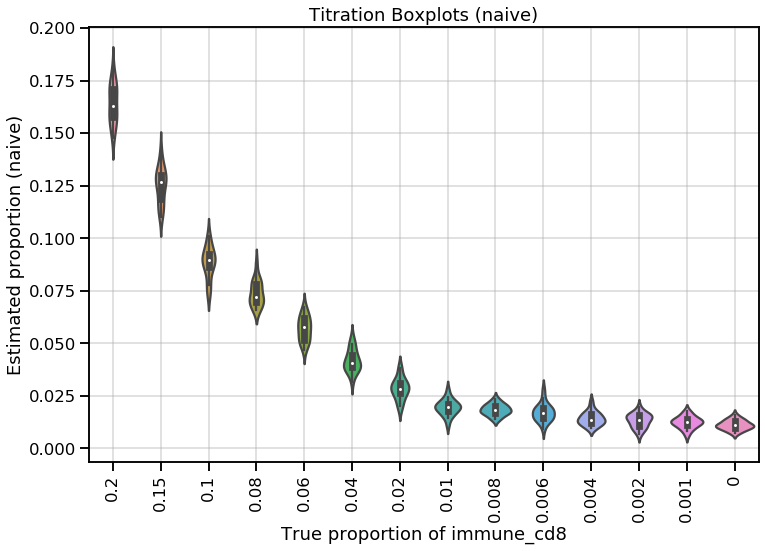

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

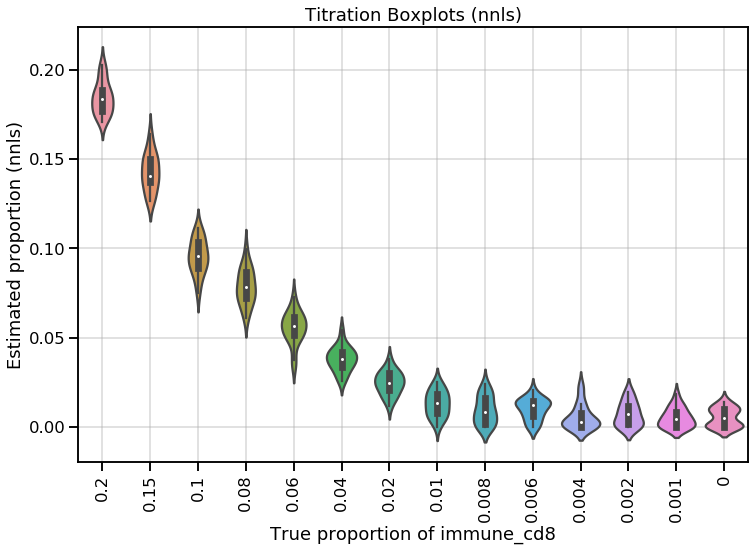

In [23]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

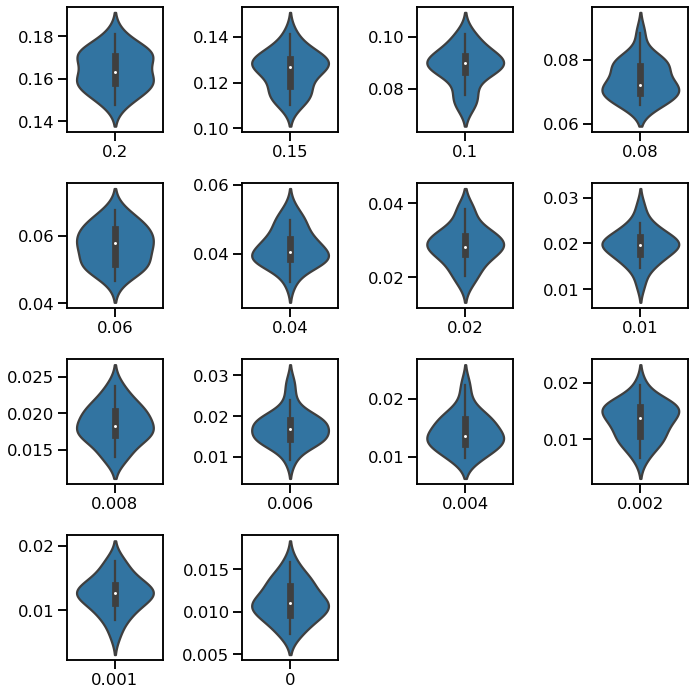

In [24]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

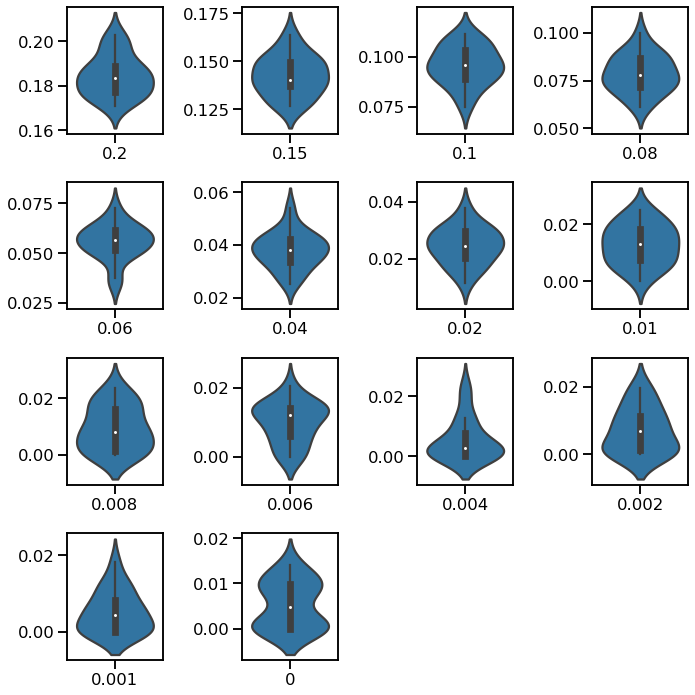

In [25]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

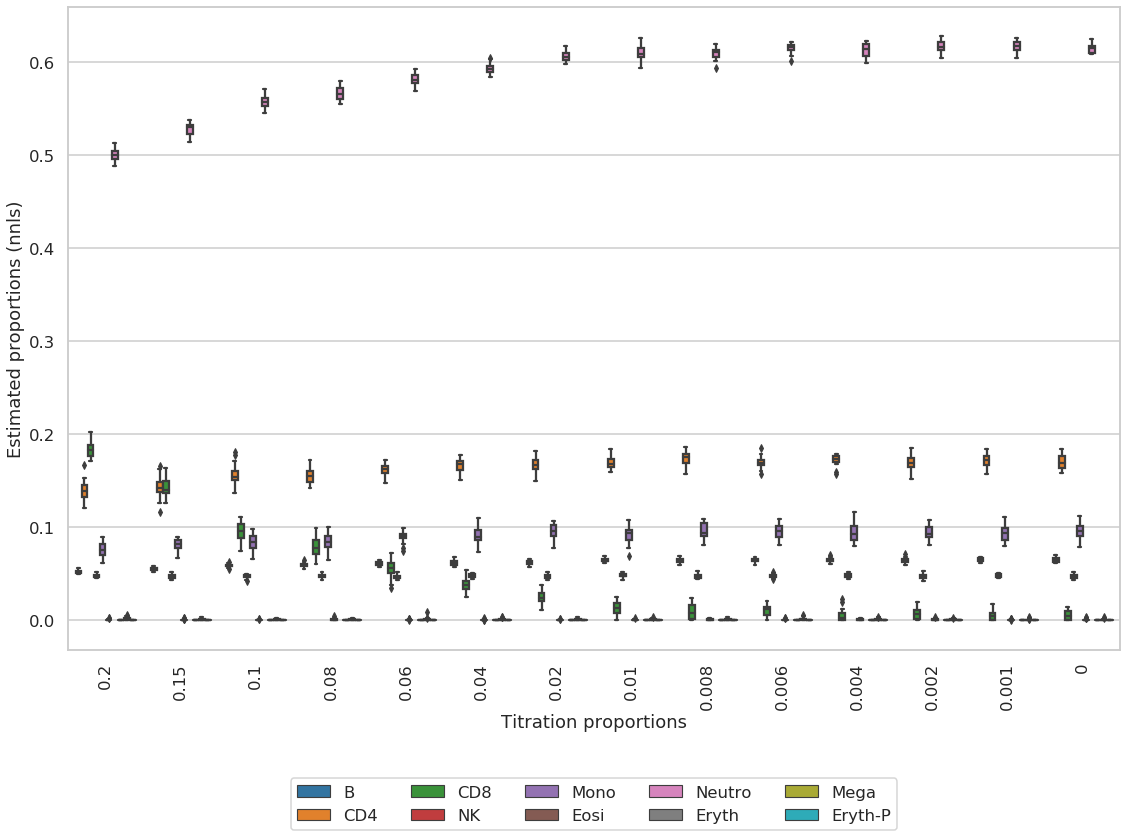

In [26]:
dcnv.background_estimates_boxplot(list_of_deconvolution_dfs = deconvolution_nnls, 
                             cell_types = ['B', 'CD4', 'CD8', 'NK', 'Mono', 'Eosi', 'Neutro', 'Eryth', 'Mega', 'Eryth-P'],
                            titration_proportions = TITRATION_LIST,
                            method = 'nnls')

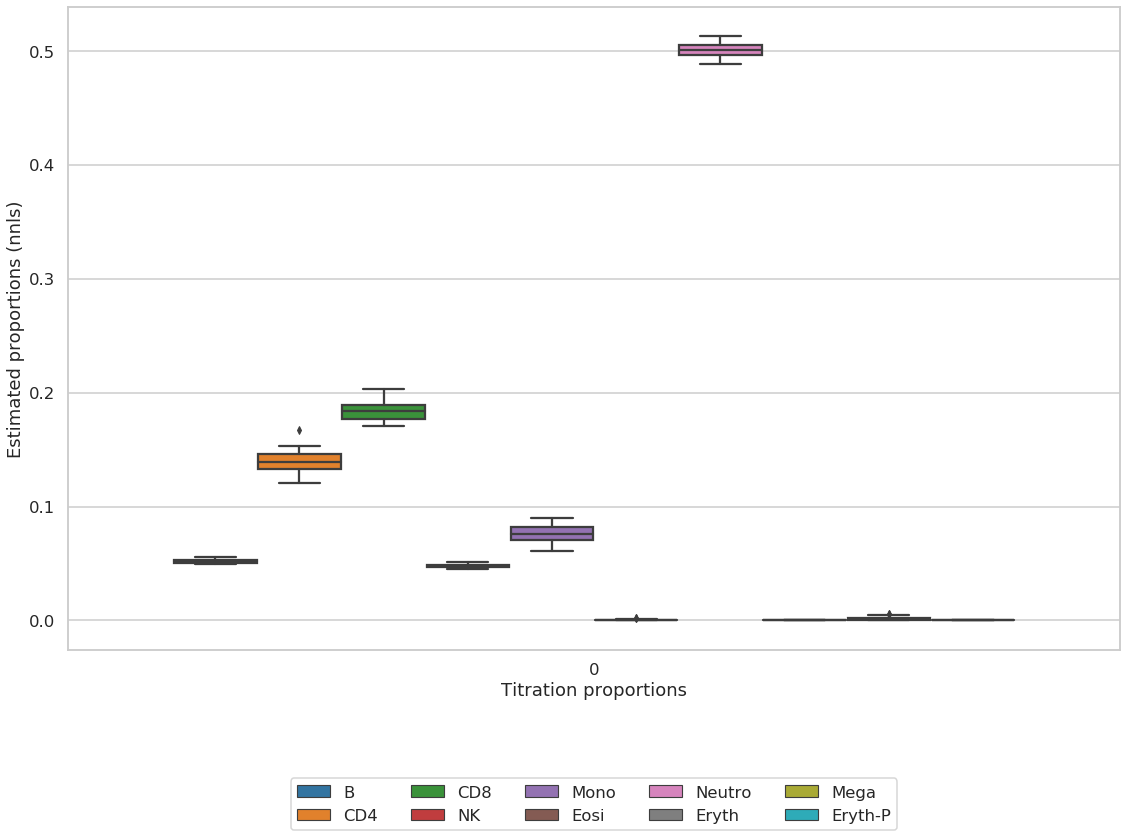

In [27]:
dcnv.background_estimates_boxplot_zoom(proportion=0.2,
                            list_of_deconvolution_dfs = deconvolution_nnls, 
                             cell_types = ['B', 'CD4', 'CD8', 'NK', 'Mono', 'Eosi', 'Neutro', 'Eryth', 'Mega', 'Eryth-P'],
                            titration_proportions = TITRATION_LIST,
                            method = 'nnls')